In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_88415/859329180.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# functions for data cleaning
# return the proportion of nan each column in the data
def na_proportion(series: pd.Series):
    return series.isna().sum() / len(series)

# returns a dataframe without the columns that have higher proportion of na 
# than threshold. 
# default threshold: 40% of nan means removal
def stripped_threshold_na_columns(df: pd.DataFrame, threshold = 0.4):
    df_return = pd.DataFrame()
    for column in df.columns:
        if na_proportion(df[column]) < threshold:
            df_return[column] = df[column]
    return df_return

# if a value occurs less than n times in a series, replace it with placeholder
def replace_less_than_n_values(series: pd.Series, n = 10, placeholder = np.nan):
    value_counts = series.value_counts()
    values_to_replace = value_counts[value_counts < n].index
    return series.replace(to_replace=values_to_replace, value=placeholder)

# returns the n most common values in a series (by default the 10 most common)
def most_common_n_values(series: pd.Series, n = 10):
    return series.value_counts()[:n].index.tolist()


# return a series with its least common values converted to a different value
# nans are also replaceable
# by default, the string 'other'
def otherise(value, most_common_values, other, nan_replace):
    if value in most_common_values:
        return value
    if value is np.nan:
        return nan_replace
    return other

def otherise_less_common_values(
        series: pd.Series, 
        most_common_values, 
        other='other', 
        nan_replace = np.nan
    ):
    return series.apply(
        lambda value: otherise(value, most_common_values, other, nan_replace)
    )


In [3]:
# tree data
df_trees = pd.read_csv('data/bomen-stamgegevens-2024-03-12T09 06 04.036291.csv')
# amsterdam neighbourhood meta data, i.e. matching neighbourhood name with ID
df_buurt_meta = pd.read_csv('data/gebieden-buurten-2024-03-12T12 09 07.653588.csv')
# amsterdam sub-district meta data, to match each neighbourhood with its district
df_wijk_meta = pd.read_csv('data/gebieden_wijken.csv')

In [4]:
# standardise names of neighbourhood id column so we can merge on that column
buurt_id_column = 'buurt_id'
wijk_id_column = 'wijk_id'

# rename buurt id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Identificatie': buurt_id_column}
)
df_trees = df_trees.rename(
    columns={'Gbdbuurtid': buurt_id_column}
)

# rename wijk id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Ligtinwijkid': wijk_id_column}
)
df_wijk_meta = df_wijk_meta.rename(
    columns={'Identificatie': wijk_id_column}
)


In [5]:
# match each buurt (neighbourhood) with its associated wijk (sub-district)
df_buurt_simple = df_buurt_meta[[
    buurt_id_column, wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_buurt_simple = df_buurt_simple.rename(
    columns={
        'Naam': 'Naam_buurt',
        'Code': 'Code_buurt',
        'Cbscode': 'Cbscode_buurt',
        'Geometrie': 'Geometrie_buurt'
    }
)

df_wijk_simple = df_wijk_meta[[
    wijk_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_wijk_simple = df_wijk_simple.rename(
    columns={
        'Naam': 'Naam_wijk',
        'Code': 'Code_wijk',
        'Cbscode': 'Cbscode_wijk',
        'Geometrie': 'Geometrie_wijk'
    }
)

df_location_data = pd.merge(df_buurt_simple, df_wijk_simple, on=wijk_id_column)

In [6]:
# clean up tree data
# removing nans
# we want to remove columns that have too many nans so that we don't reduce
# the entire dataset too much by using .dropna
# I will make an exception for Standplaatsgedetailleerd (middle in which tree
# is grown) since that seems like an interesting statistic (unlike e.g. diameter)
print(f'nan proportion Standplaatsgedetailleerd {na_proportion(df_trees['Standplaatsgedetailleerd'])}')
# this will remove 62% of the data, out of 280000 so we should be fine
growth_ground = df_trees['Standplaatsgedetailleerd']

print(f'shape before dropna: {df_trees.shape}')

df_trees = stripped_threshold_na_columns(df_trees)
df_trees['growth_ground'] = growth_ground
df_trees.dropna(inplace=True)

print(f'shape after dropna: {df_trees.shape}')


nan proportion Standplaatsgedetailleerd 0.620510336029891
shape before dropna: (286909, 14)


shape after dropna: (98285, 13)


In [7]:
# height
# we only have approximate measures for tree height :(
# Brute force normalising it to numbers to avoid using regex and preserve my sanity
# There are some limitations from applying a linear regression model
# to height that is calculated this way.
def extract_height_data(data):
    if data == 'a. tot 6 m.':
        return 3
    if data == 'b. 6 tot 9 m.':
        return 7.5
    if data == 'c. 9 tot 12 m.':
        return 10.5
    if data == 'd. 12 tot 15 m.':
        return 13.5
    if data == 'e. 15 tot 18 m.':
        return 16.5
    if data == 'f. 18 tot 24 m.':
        return 21
    if data == 'g. 24 m. en hoger':
        return 24
    # if not any of the above return nan
    return np.nan

df_trees['tree_height'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data(x)
)

df_trees.dropna(inplace=True)




Text(0, 0.5, 'Frequency')

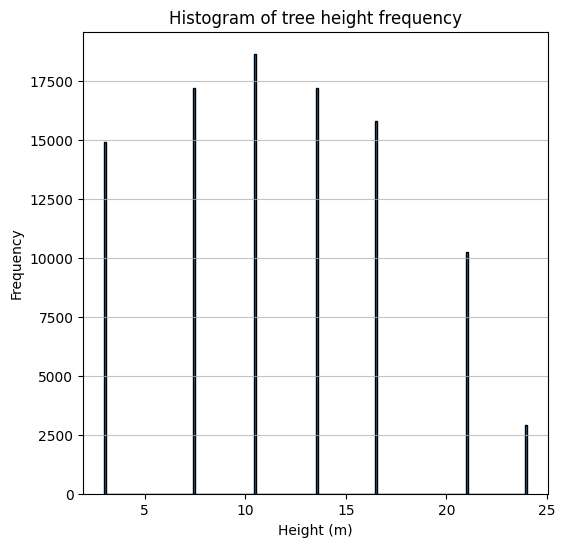

In [8]:
# visualise tree height distribution
plt.figure(figsize=(6, 6))
plt.hist(df_trees['tree_height'], bins=200, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of tree height frequency")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")


In [9]:
# neighbourhood that tree is in (ID)
print(df_trees['buurt_id'].value_counts())

buurt_id
3.630980e+12    2617
3.630980e+12    1912
3.630980e+12    1562
3.630980e+12    1193
3.630980e+12    1188
                ... 
3.630980e+12       3
3.630980e+12       2
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
Name: count, Length: 494, dtype: int64


In [10]:
# tree administrator ('Typebeheerderplus')
# categorical
print(df_trees['Typebeheerderplus'].value_counts())
admin_threshold = 15
df_trees['tree_admin'] = replace_less_than_n_values(
    df_trees['Typebeheerderplus'],
    admin_threshold
)
print(f'proportion of nan for admin after removal: {na_proportion(df_trees['Typebeheerderplus'])}')

df_trees.dropna(inplace=True)

Typebeheerderplus
R&E_VOR_Bomen                     94378
Recreatieschap Noord-Holland       1386
Gemeente Amsterdam, rve Sport       444
RVE Spieringhorn Sportpark          342
R&E_VOR_Groen                        84
Amsterdamse Bos                      63
Rijkswaterstaat                      49
Gemeentelijk Vastgoed                35
Amsterdamse bos - eigen dienst       34
RVE Spieringpark                     23
Stichting                             8
Havenbedrijf                          6
Volkstuinpark                         3
Begraafplaats Ransdorp                3
Woningcorporatie                      2
Begraafplaats Nieuwendam              2
Natuurlijk persoon                    2
Schooltuinen                          1
Westpoort                             1
SOC_S&B_Sport                         1
Name: count, dtype: int64
proportion of nan for admin after removal: 0.0


In [11]:
print(df_trees['tree_admin'].value_counts())

tree_admin
R&E_VOR_Bomen                     94378
Recreatieschap Noord-Holland       1386
Gemeente Amsterdam, rve Sport       444
RVE Spieringhorn Sportpark          342
R&E_VOR_Groen                        84
Amsterdamse Bos                      63
Rijkswaterstaat                      49
Gemeentelijk Vastgoed                35
Amsterdamse bos - eigen dienst       34
RVE Spieringpark                     23
Name: count, dtype: int64


In [12]:
# municipality that owns the trees
print(df_trees['Typeeigenaarplus'].value_counts())
# the overwhelming majority of trees are owned by amsterdam.
# let's have values for just "amsterdam" and "not amsterdam"
amsterdam_ownership = ['Gemeente Amsterdam']
df_trees['tree_municipality'] = otherise_less_common_values(
    df_trees['Typeeigenaarplus'], amsterdam_ownership
)

Typeeigenaarplus
Gemeente Amsterdam       94254
Gemeente Weesp            2337
Gemeentelijk Vastgoed      232
Gemeente Diemen              8
Gemeente Ouder-Amstel        7
Name: count, dtype: int64


In [13]:
df_trees['tree_municipality'].value_counts()

tree_municipality
Gemeente Amsterdam    94254
other                  2584
Name: count, dtype: int64

In [14]:
# tree planting year
print(
    f'proportion of nan for planting year: {na_proportion(df_trees['Jaarvanaanleg'])}'
)
# not many nans :)
print(df_trees['Jaarvanaanleg'].value_counts())
# lots of zeros :(
# Removing all the rows with nonsensical years
year_threshold = 1500 # let's admit really old trees because they are awesome
df_trees = df_trees[df_trees.Jaarvanaanleg > year_threshold]


proportion of nan for planting year: 0.0
Jaarvanaanleg
1990.0    6338
0.0       5914
1970.0    5530
1980.0    4918
1985.0    4763
          ... 
1921.0       1
1890.0       1
200.0        1
20.0         1
1881.0       1
Name: count, Length: 131, dtype: int64


<Axes: xlabel='Jaarvanaanleg', ylabel='Count'>

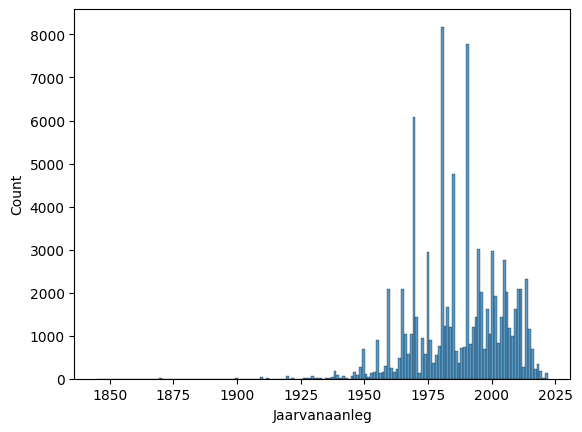

In [15]:
sns.histplot(df_trees['Jaarvanaanleg'])

In [16]:
# there are three columns for the species of the tree
# Soortnaam: specific latin name species
print(df_trees['Soortnaam'].value_counts())
# Sortnaamkort/Sortnaamtop are for grouped species (they're the same)
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
print(df_trees['Soortnaamkort'].value_counts())
print(f'nan proportion Soortnaamtop: {na_proportion(df_trees['Soortnaamtop'])}')
print(df_trees['Soortnaamtop'].value_counts())

# let's choose both, even if they will by definition be highly correlated in some ways

Soortnaam
Platanus hispanica               5463
Fraxinus excelsior               3001
Quercus robur                    2669
Acer campestre                   2578
Salix alba                       2483
                                 ... 
Acer negundo 'Flamingo'             1
Acer pseudoplatanus 'Wilhelm'       1
Prunus serrulata 'Asano'            1
Picea                               1
Fagus sylvatica 'Rohanii'           1
Name: count, Length: 911, dtype: int64
nan proportion Soortnaamkort: 0.0
Soortnaamkort
Tilia          10268
Ulmus          10243
Acer            9097
Fraxinus        7349
Platanus        5758
               ...  
Platycladus        1
Sciadopitys        1
Diospyros          1
Viburnum           1
Cupressus          1
Name: count, Length: 105, dtype: int64
nan proportion Soortnaamtop: 0.0
Soortnaamtop
Linde (Tilia)         10268
Iep (Ulmus)           10243
Esdoorn (Acer)         9097
Es (Fraxinus)          7349
Plataan (Platanus)     5758
                      ...  
S

In [17]:
# Soortnaam (exact species)
# How many species are there?
print(f'number of species: {df_trees['Soortnaam'].value_counts().shape}')
# let's remove trees which species there are too few of
species_threshold = 10
df_trees['species'] = replace_less_than_n_values(
    df_trees['Soortnaam'],
    species_threshold
)
# how much did that remove?
print(f'number of species after removal: {df_trees['species'].value_counts().shape}')
print(f'nan proportion Soortnaam after removal: {na_proportion(df_trees['species'])}')
df_trees.dropna(inplace=True)

number of species: (911,)
number of species after removal: (413,)
nan proportion Soortnaam after removal: 0.017168939727232733


In [18]:
# Soortnaamkort (species group)
# How many groups are there?
print(f'number of species groups: {df_trees['Soortnaamkort'].value_counts().shape}')
# proportion of nan?
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
# let's remove trees which species group there are too few of
gr_species_threshold = 10
df_trees['species_group'] = replace_less_than_n_values(
    df_trees['Soortnaamkort'],
    gr_species_threshold
)
# how much did that remove?
print(f'number of species groups after removal: {df_trees['species_group'].value_counts().shape}')
print(f'nan proportion species_group after removal: {na_proportion(df_trees['species_group'])}')
df_trees.dropna(inplace=True)


number of species groups: (65,)
nan proportion Soortnaamkort: 0.0
number of species groups after removal: (65,)
nan proportion species_group after removal: 0.0


In [19]:
# Typeobject (status of the object)
print(f'{df_trees['Typeobject'].value_counts()}')
# seems fine already. will just nan up the one boomstam_algemeen
df_trees['tree_treatment'] = replace_less_than_n_values(df_trees['Typeobject'])
df_trees.dropna(inplace=True)

Typeobject
Boom niet vrij uitgroeiend    75000
Boom vrij uitgroeiend          7805
Knotboom                       2545
Vormboom                       1688
Gekandelaberde boom            1482
Stobbe                          708
Leiboom                         121
Fruitboom                        10
Name: count, dtype: int64


In [20]:
# Typesoortnaam (the sort of thing that this is)
print(df_trees['Typesoortnaam'].value_counts())
# we are only interested in trees
only_trees = most_common_n_values(df_trees['Typesoortnaam'], n = 1)
df_trees['plant_type'] = otherise_less_common_values(
    df_trees['Typesoortnaam'],
    only_trees,
    other = np.nan
)
df_trees.dropna(inplace=True)

Typesoortnaam
Bomen       89341
Heesters       16
Algemeen        2
Name: count, dtype: int64


In [21]:
# number of trees left
print(df_trees.shape)

(89341, 20)


In [22]:
df_with_location = pd.merge(df_trees, df_location_data, on=buurt_id_column)
display(df_with_location.sample(10).head())
print(df_with_location.columns)

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,Jaarvanaanleg,Soortnaam,Typeobject,Typesoortnaam,...,plant_type,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk
43358,1047108,3.630980e+12,SRID=28992;POINT (123500.67 489618.96),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1980.0,Robinia pseudoacacia,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000091,Nieuwendammerdijk-West,NF03,BU0363NF03,"SRID=28992;POLYGON ((124220.063 489566.41, 124...",Nieuwendammerdijk/Buiksloterdijk,NF,WK0363NF,"SRID=28992;POLYGON((124627.886 489359.874,1246..."
26457,994940,3.630980e+12,SRID=28992;POINT (120165.16 484890.78),R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Amsterdam,1975.0,Tilia europaea 'Euchlora',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000063,Hiltonbuurt,KJ01,BU0363KJ01,"SRID=28992;POLYGON ((120271.717 484962.66, 120...",Apollobuurt,KJ,WK0363KJ,"SRID=28992;POLYGON((120868.184 484624.849,1207..."
33314,1015169,3.630980e+12,SRID=28992;POINT (119856.68 488772.44),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2001.0,Styphnolobium japonicum,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000021,Westergasfabriek,EB09,BU0363EB09,"SRID=28992;POLYGON ((120386.946 488993.61, 120...",Spaarndammerbuurt/Zeeheldenbuurt,EB,WK0363EB,"SRID=28992;POLYGON((120858.696 489329.761,1208..."
34297,1018079,3.630980e+12,SRID=28992;POINT (120101.25 488505.66),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1991.0,Acer negundo,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000027,Fannius Scholtenbuurt,EH02,BU0363EH02,"SRID=28992;POLYGON ((120128.615 488766.03, 119...",Staatsliedenbuurt,EH,WK0363EH,"SRID=28992;POLYGON((120441.569 488350.659,1204..."
18470,974386,3.630980e+12,SRID=28992;POINT (127335.29434293 481241.71033...,R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,1977.0,Carpinus betulus,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000112,Bijlmermuseum-Zuid,TG02,BU0363TG02,"SRID=28992;POLYGON ((127167.415 481588.127, 12...",Bijlmermuseum,TG,WK0363TG,"SRID=28992;POLYGON((127640.202 481122.04,12762..."


Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'Jaarvanaanleg',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'tree_height', 'tree_admin',
       'tree_municipality', 'species', 'species_group', 'tree_treatment',
       'plant_type', 'wijk_id', 'Naam_buurt', 'Code_buurt', 'Cbscode_buurt',
       'Geometrie_buurt', 'Naam_wijk', 'Code_wijk', 'Cbscode_wijk',
       'Geometrie_wijk'],
      dtype='object')


In [23]:
# parking data
df_parking = pd.read_csv('data/parking_data_amsterdam.csv')


In [24]:
# some info about this dataset
print(f'shape of parking dataset: {df_parking.shape}')
print(f'columns: {df_parking.columns}')
parking_count_per_buurt = df_parking['buurtcode'].value_counts()
parking_per_neighbourhood = pd.DataFrame({
    'Code_buurt': parking_count_per_buurt.index,
    'parked_cars_in_neighbourhood': parking_count_per_buurt.values
})
print(parking_per_neighbourhood)


shape of parking dataset: (266622, 9)
columns: Index(['WKT', 'id', 'buurtcode', 'straatnaam', 'type', 'soort', 'e_type',
       'aantal', 'versiedatum'],
      dtype='object')
    Code_buurt  parked_cars_in_neighbourhood
0         KQ05                          2986
1         KR03                          2385
2         FH02                          2373
3         FA03                          2348
4         MN03                          2231
..         ...                           ...
497       AD08                             7
498       TA05                             6
499       NQ07                             4
500       FN03                             4
501       MP02                             2

[502 rows x 2 columns]


In [27]:
df_with_parking = pd.merge(
    df_with_location, 
    parking_per_neighbourhood,
    on='Code_buurt'
)
display(df_with_parking.sample(10).head())

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,Jaarvanaanleg,Soortnaam,Typeobject,Typesoortnaam,...,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk,parked_cars_in_neighbourhood
14066,965880,3.630980e+12,SRID=28992;POINT (128209.13 478752.73),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1990.0,Acer saccharinum,Boom niet vrij uitgroeiend,Bomen,...,3630970000117,Gein 4,TM04,BU0363TM04,"SRID=28992;POLYGON ((128603.815 478241.28, 128...",Gein,TM,WK0363TM,"SRID=28992;POLYGON((128710.211 478582.637,1287...",1642
28183,1005518,3.630980e+12,SRID=28992;POINT (120989.47 481975.48),R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,1966.0,Malus floribunda,Boom niet vrij uitgroeiend,Bomen,...,3630970000070,Buitenveldert-Zuidoost,KR03,BU0363KR03,"SRID=28992;POLYGON ((121106.124 482500.747, 12...",Buitenveldert-Oost,KR,WK0363KR,"SRID=28992;POLYGON((121706.41 482874.35,121615...",2385
29365,1008600,3.630980e+12,SRID=28992;POINT (118678.4 489470.74),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1964.0,Ulmus hollandica 'Vegeta',Boom niet vrij uitgroeiend,Bomen,...,3630970000020,Contactbuurt,EA02,BU0363EA02,"SRID=28992;POLYGON ((118942.25 489501.497, 118...",Sloterdijk-West,EA,WK0363EA,"SRID=28992;POLYGON((118942.25 489501.497,11892...",795
65713,1113753,3.630980e+12,SRID=28992;POINT (122572.374026477 488419.4410...,R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Amsterdam,1965.0,Platanus orientalis 'Digitata',Boom niet vrij uitgroeiend,Bomen,...,3630970000096,IJplein e.o.,NL04,BU0363NL04,"SRID=28992;POLYGON ((123120.354 488731.458, 12...",IJplein/Vogelbuurt,NL,WK0363NL,"SRID=28992;POLYGON((123460.458 488957.324,1235...",1187
60337,1100387,3.630980e+12,SRID=28992;POINT (114971.66 486849.08),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,2014.0,Tilia europaea,Boom niet vrij uitgroeiend,Bomen,...,3630970000045,Ookmeer,FF02,BU0363FF02,"SRID=28992;POLYGON ((115370.192 487357.932, 11...",Lutkemeer/Ookmeer,FF,WK0363FF,"SRID=28992;POLYGON((115370.192 487357.932,1150...",1176
